# **Detecting Machine-Generated Academic Text Using Supervised Learning**

In [4]:
!pip install spacy textstat nltk
!python -m spacy download en_core_web_sm
#Install transformers if not already
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 122.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Standard Libraries
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json

# Sklearn (classic ML Libraries)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc

# Deep Learning Libraries
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, GPT2LMHeadModel, GPT2TokenizerFast
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, Dataset
from torch.optim import AdamW

# Other Utilities Libraries
#from scipy.sparse import hstack
from tqdm import tqdm
import time
import spacy
import textstat

import nltk
from nltk.tokenize import TreebankWordTokenizer
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Data Collection**

In [6]:
# Reads file
def read_data(fname):
    return pd.read_csv(fname)

In [7]:
filepath1 = "/content/drive/MyDrive/Dessertation/Training_Essay_Data.csv"

# Load dataset
essay_df = read_data(filepath1)

# Display basic information
print("First 5 rows of the dataset:")
display(essay_df.head())

First 5 rows of the dataset:


,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


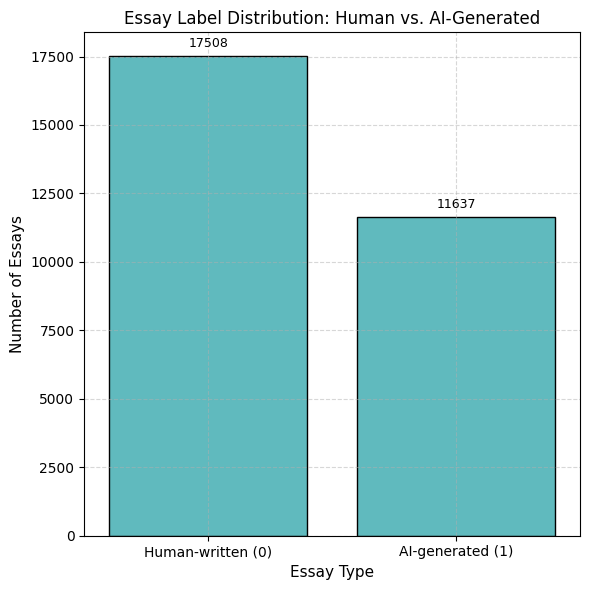

In [8]:
# Counting label distribution
label_counts = essay_df['generated'].value_counts().sort_index()
label_names = ['Human-written (0)', 'AI-generated (1)']

# Plot
plt.figure(figsize = (6, 6))  # Set figure size
ax = sns.barplot(x = label_names, y = label_counts.values, color = "#50C9CE", edgecolor = 'black')

# Titles and labels
plt.title("Essay Label Distribution: Human vs. AI-Generated", fontsize = 12)
plt.xlabel("Essay Type", fontsize = 11)
plt.ylabel("Number of Essays", fontsize = 11)

# Gridlines
plt.grid(visible = True, linestyle = '--', alpha = 0.5)

# Annotate values on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', fontsize = 9, color = 'black', xytext = (0, 9), textcoords = 'offset points')

# Adjust tick sizes
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

# Layout and show
plt.tight_layout()
plt.show()

## **EDA & Pre-Processing**

In [9]:
# Rename columns
essay_df.rename(columns = {"text": "essay_content", "generated": "label_ai_written"}, inplace = True)

In [10]:
# Summary statistics
print("Dataset Info:\n")
print(essay_df.info())
print(essay_df.describe())

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   essay_content     29145 non-null  object
 1   label_ai_written  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB
None
       label_ai_written
count      29145.000000
mean           0.399279
std            0.489759
min            0.000000
25%            0.000000
50%            0.000000
75%            1.000000
max            1.000000


There are no null values.

### Basic Dataset inspection

In [11]:
# 1: Check for empty text entries

num_empty = (essay_df['essay_content'].str.strip() == '').sum()

# 2: Check for duplicate entries
num_duplicates = essay_df.duplicated(subset = 'essay_content').sum()

# 3: Check essay length stats (characters and words)
essay_df['char_count'] = essay_df['essay_content'].str.len()
essay_df['word_count'] = essay_df['essay_content'].str.split().apply(len)

char_stats = essay_df['char_count'].describe()
word_stats = essay_df['word_count'].describe()

# Print results
print("Dataset Diagnostics:\n")
print(f"Empty text entries: {num_empty}")
print(f"Duplicate text entries: {num_duplicates}\n")

print("Character Count Stats:")
print(char_stats)

print("\nWord Count Stats:")
print(word_stats)

Dataset Diagnostics:

Empty text entries: 0
Duplicate text entries: 1805

Character Count Stats:
count    29145.00000
mean      2235.99674
std        987.34624
min          1.00000
25%       1505.00000
50%       2158.00000
75%       2750.00000
max       9157.00000
Name: char_count, dtype: float64

Word Count Stats:
count    29145.000000
mean       383.144519
std        171.845881
min          1.000000
25%        263.000000
50%        351.000000
75%        474.000000
max       1650.000000
Name: word_count, dtype: float64


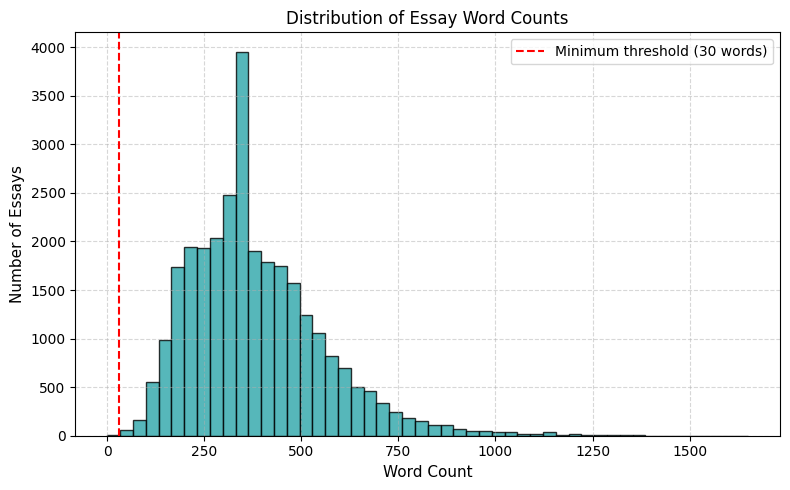

In [12]:
essay_df['word_count'] = essay_df['essay_content'].str.split().apply(len)

# Histogram of word counts
plt.figure(figsize = (8, 5))
plt.hist(essay_df['word_count'], bins = 50, color = "#2CA5A9", edgecolor = 'black', alpha = 0.8)

# Add line for filtering threshold
plt.axvline(x = 30, color = 'red', linestyle = '--', label = 'Minimum threshold (30 words)')

# Titles and labels
plt.title("Distribution of Essay Word Counts", fontsize = 12)
plt.xlabel("Word Count", fontsize = 11)
plt.ylabel("Number of Essays", fontsize = 11)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()
plt.tight_layout()
plt.show()

Essays below 30 words are too short to express meaningful structure. Stylometric features like type-token ratio or POS patterns become unstable in very short texts. Keeping the threshold low (but not too low) avoids discarding useful data while removing noise.

### Data Cleaning

In [13]:
# Remove duplicate texts
essay_df = essay_df.drop_duplicates(subset = 'essay_content').reset_index(drop = True) # by default keeping the first entry

# Filter out too-short essays (e.g., less than 30 words)
essay_df = essay_df[essay_df['word_count'] >= 30].reset_index(drop = True)

# Re-check shape
print(f"Cleaned dataset shape: {essay_df.shape}")

Cleaned dataset shape: (27335, 4)


### Label Distribution After Cleaning

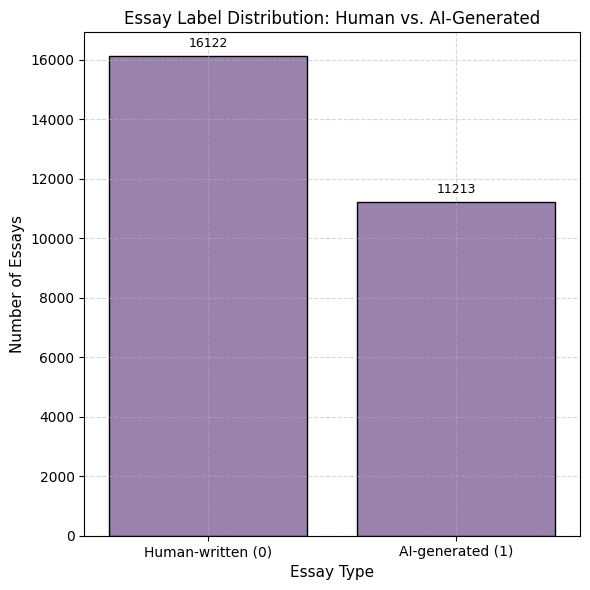

In [14]:
# Counting label distribution
label_counts = essay_df['label_ai_written'].value_counts().sort_index()
label_names = ['Human-written (0)', 'AI-generated (1)']

# Plot
plt.figure(figsize = (6, 6))  # Set figure size
ax = sns.barplot(x = label_names, y = label_counts.values, color = "#9b7bb5", edgecolor = 'black')

# Titles and labels
plt.title("Essay Label Distribution: Human vs. AI-Generated", fontsize = 12)
plt.xlabel("Essay Type", fontsize = 11)
plt.ylabel("Number of Essays", fontsize = 11)

# Gridlines
plt.grid(visible = True, linestyle = '--', alpha = 0.5)

# Annotate values on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', fontsize = 9, color = 'black', xytext = (0, 9), textcoords = 'offset points')

# Adjust tick sizes
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

# Layout and show
plt.tight_layout()
plt.show()

After cleaning, the dataset contains 29,145 essays:
- 16,122 human-written (55.3%)
- 11,213 AI-generated (44.7%)



##**Data Split**

### Split Dataset into Model Devolopment and Test 70:30

In [15]:
# Step 1: Split 70% train+val, 30% final test
model_dev_df, test_df = train_test_split(essay_df, test_size = 0.3, stratify = essay_df['label_ai_written'], random_state = 42)

To prevent data leakage and maintain generalization integrity, the cleaned dataset was first split into a development set (70%) and a held-out test set (30%). All feature extraction, model training, and hyperparameter tuning were conducted exclusively on the development set. Final evaluation metrics were computed using the untouched test set.


### Split Model Development set into train and validation 80:20

In [16]:
# Step 2: Split train_dev into train and validation (80:20)
train_df, val_df = train_test_split(model_dev_df, test_size = 0.2, stratify = model_dev_df['label_ai_written'], random_state = 42)

Model Development set is further divided into train (80%) andvalidation set (20%).

In [17]:
# Confirm sizes
print("Model Dvelopment set:")
print(len(model_dev_df))
display(model_dev_df['label_ai_written'].value_counts())
print("--------------------------------------------")

print("Test set:")
print(len(test_df))
display(test_df['label_ai_written'].value_counts())
print("--------------------------------------------")

print("Training set:")
print(len(train_df))
display(train_df['label_ai_written'].value_counts())
print("--------------------------------------------")

print("Validation set:")
print(len(val_df))
display(val_df['label_ai_written'].value_counts())

Model Dvelopment set:
19134


,count
label_ai_written,
0,11285
1,7849


--------------------------------------------
Test set:
8201


,count
label_ai_written,
0,4837
1,3364


--------------------------------------------
Training set:
15307


,count
label_ai_written,
0,9028
1,6279


--------------------------------------------
Validation set:
3827


,count
label_ai_written,
0,2257
1,1570


# **Model Development**

## **1. Stylometric Classification using Traditional Machine Learning**

### Stylometric Feature Extraction Function

This function extracts key linguistic features from each essay to help distinguish between human-written and AI-generated texts. These features are grounded in stylometry (the study of writing style patterns).


In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Stylometric Feature Extraction Function
tokenizer = TreebankWordTokenizer()

def extract_stylometric_features(text):
  doc = nlp(text)
  '''# Sentence length
  num_sentences = len(list(doc.sents))
  num_words = len([token for token in doc if token.is_alpha])
  avg_sentence_len = num_words / num_sentences if num_sentences > 0 else 0'''

  # Sentence length variance
  sentence_lengths = [len(sent.text.split()) for sent in doc.sents]
  sentence_len_var = np.var(sentence_lengths) if len(sentence_lengths) > 1 else 0

  # Type-token ratio (using Treebank tokenizer)
  tokens = tokenizer.tokenize(text)
  words = [word.lower() for word in tokens if word.isalpha()]
  ttr = len(set(words)) / len(words) if len(words) > 0 else 0

  # POS ratios
  pos_counts = doc.count_by(spacy.attrs.POS)
  total_pos = sum(pos_counts.values())
  pos_norm = {doc.vocab[pos].text: count / total_pos for pos, count in pos_counts.items()}

  noun_ratio = pos_norm.get('NOUN', 0)
  verb_ratio = pos_norm.get('VERB', 0)
  adj_ratio = pos_norm.get('ADJ', 0)

  # Punctuation frequency
  punct_count = sum(1 for token in doc if token.is_punct)
  punct_freq = punct_count / len(doc) if len(doc) > 0 else 0

  # Readability
  readability = textstat.flesch_reading_ease(text)

  return {'sentence_len_var': sentence_len_var, #'avg_sentence_len': avg_sentence_len,
          'type_token_ratio': ttr,
          'noun_ratio': noun_ratio,
          'verb_ratio': verb_ratio,
          'adj_ratio': adj_ratio,
          'punct_freq': punct_freq,
          'readability': readability}

### Extract Stylometric Features

The below code will take 30 mins

In [ ]:
# Train
train_features = train_df['essay_content'].apply(extract_stylometric_features).apply(pd.Series)
train_features['label'] = train_df['label_ai_written'].values

# Validation
val_features = val_df['essay_content'].apply(extract_stylometric_features).apply(pd.Series)
val_features['label'] = val_df['label_ai_written'].values

# Test
test_features = test_df['essay_content'].apply(extract_stylometric_features).apply(pd.Series)
test_features['label'] = test_df['label_ai_written'].values

### Saving the Features

In [20]:
train_stylometric_features_savingpath = "/content/drive/MyDrive/Dessertation/train_stylometric_features3.csv"
val_stylometric_features_savingpath = "/content/drive/MyDrive/Dessertation/val_stylometric_features3.csv"
test_stylometric_features_savingpath = "/content/drive/MyDrive/Dessertation/test_stylometric_features3.csv"

In [18]:
# Save feature DataFrames to CSV
train_features.to_csv(train_stylometric_features_savingpath, index = False)
val_features.to_csv(val_stylometric_features_savingpath, index = False)
test_features.to_csv(test_stylometric_features_savingpath, index = False)

### Loading the features

In [21]:
train_features = pd.read_csv(train_stylometric_features_savingpath)
val_features = pd.read_csv(val_stylometric_features_savingpath)
test_features = pd.read_csv(val_stylometric_features_savingpath)

In [22]:
train_features

,sentence_len_var,type_token_ratio,noun_ratio,verb_ratio,adj_ratio,punct_freq,readability,label
0,58.507804,0.495614,0.209507,0.114437,0.059859,0.146127,69.285225,0
1,47.609467,0.465517,0.201439,0.104317,0.071942,0.089928,72.076857,0
2,182.198347,0.747774,0.298701,0.142857,0.077922,0.080519,4.308574,1
3,353.290000,0.709877,0.260417,0.117188,0.096354,0.096354,17.556765,1
4,1550.960000,0.540670,0.153846,0.126697,0.099548,0.031674,14.360411,0
...,...,...,...,...,...,...,...,...
15302,18.210000,0.451923,0.185950,0.095041,0.099174,0.082645,60.443601,1
15303,679.715556,0.405242,0.159555,0.157699,0.059369,0.033395,52.325599,0
15304,100.000000,0.463636,0.165669,0.149701,0.061876,0.065868,67.624783,0
15305,36.859375,0.598802,0.266667,0.143590,0.102564,0.076923,12.531304,1


### Prepare Train/Val/Test Matrices

In [23]:
# Separate X and y for each
X_train = train_features.drop(columns = ['label'])
y_train = train_features['label']

X_val = val_features.drop(columns = ['label'])
y_val = val_features['label']

X_test = test_features.drop(columns = ['label'])
y_test = test_features['label']

##**1a. Logistic Regression**

### Training and Validating Logistic Regression

In [24]:
# Train logistic regression model
stylometric_lr_model = LogisticRegression(max_iter = 1000, random_state = 42)
stylometric_lr_model.fit(X_train, y_train)

# Validate on val set
val_preds_lr = stylometric_lr_model.predict(X_val)
val_probs_lr = stylometric_lr_model.predict_proba(X_val)[:, 1]

print("Validation (Logistic Regression):")
print(classification_report(y_val, val_preds_lr, digits = 3))
print("ROC-AUC (Val):", round(roc_auc_score(y_val, val_probs_lr), 3))

Validation (Logistic Regression):
              precision    recall  f1-score   support

           0      0.864     0.930     0.896      2257
           1      0.887     0.790     0.836      1570

    accuracy                          0.873      3827
   macro avg      0.876     0.860     0.866      3827
weighted avg      0.874     0.873     0.871      3827

ROC-AUC (Val): 0.925


#### Hyperparameter Tuning: Logistic Regression through GridSearchCV

In [25]:
# Hyperparameter grid for logistic regression
lr_param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'class_weight': [None, 'balanced'], 'solver': ['liblinear']}

# Grid search setup
lr_grid = GridSearchCV(estimator = LogisticRegression(max_iter = 1000, random_state = 42),
                       param_grid = lr_param_grid,
                       scoring = 'f1',
                       cv = 5,
                       n_jobs = -1,
                       verbose = 1)

# Fit on training set only
lr_grid.fit(X_train, y_train)

# Best model
best_lr_model = lr_grid.best_estimator_
print(best_lr_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')


In [26]:
# Validation performance
val_preds_tuned = best_lr_model.predict(X_val)
val_probs_tuned = best_lr_model.predict_proba(X_val)[:, 1]

print("Validation (Tuned Logistic Regression):")
print(classification_report(y_val, val_preds_tuned, digits = 3))
print("ROC-AUC (Val):", round(roc_auc_score(y_val, val_probs_tuned), 3))

Validation (Tuned Logistic Regression):
              precision    recall  f1-score   support

           0      0.886     0.885     0.885      2257
           1      0.835     0.836     0.835      1570

    accuracy                          0.865      3827
   macro avg      0.860     0.860     0.860      3827
weighted avg      0.865     0.865     0.865      3827

ROC-AUC (Val): 0.931


### Final Test Evaluation for Logistic Regression



Test (Tuned Logistic Regression):
              precision    recall  f1-score   support

           0      0.880     0.885     0.882      4837
           1      0.833     0.826     0.830      3364

    accuracy                          0.861      8201
   macro avg      0.856     0.855     0.856      8201
weighted avg      0.861     0.861     0.861      8201

ROC-AUC (Test): 0.926


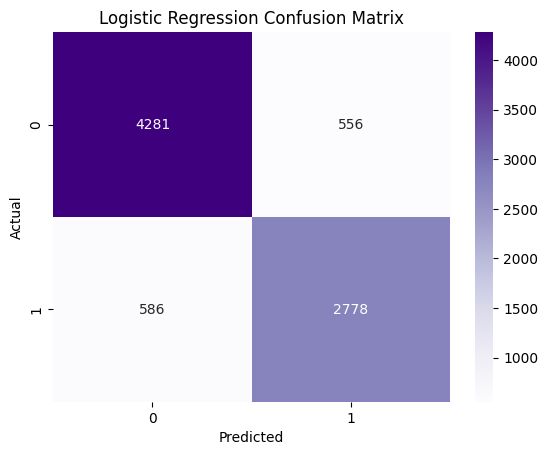

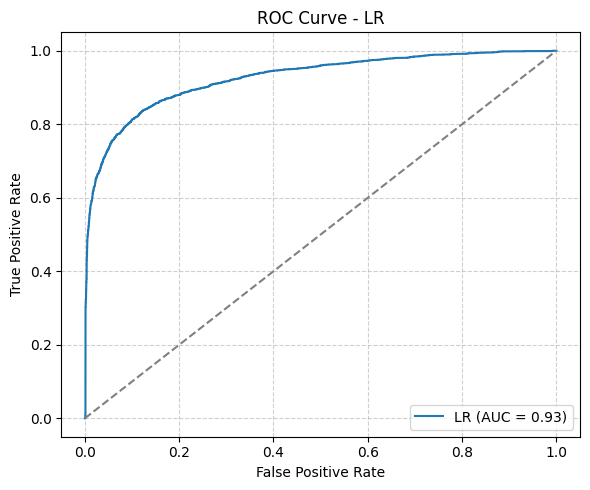

In [ ]:
# Test performance
test_preds_tuned = best_lr_model.predict(X_test)
test_probs_tuned = best_lr_model.predict_proba(X_test)[:, 1]

print("\n\nTest (Tuned Logistic Regression):")
print(classification_report(y_test, test_preds_tuned, digits = 3))
print("ROC-AUC (Test):", round(roc_auc_score(y_test, test_probs_tuned), 3))

# Plot
# Confusion matrix
lr_cm = confusion_matrix(y_test, test_preds_tuned)
sns.heatmap(lr_cm, annot = True, fmt = 'd', cmap = 'Purples')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, test_probs_tuned)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, label = f"LR (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LR")
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()

Logistic regression model is not overfitting. The The test set is larger, naturally a bit more challenging so slight drops are statistically normal and acceptable.

## **1b. Support Vector Machine (SVM)**

In [ ]:
base_linear_svc = LinearSVC(random_state = 42, max_iter = 5000)
stylometric_svm_model = CalibratedClassifierCV(base_linear_svc, cv = 3)
stylometric_svm_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LinearSVC(max_iter=5000, random_state=42))

In [ ]:
# Validation evaluation
val_preds_svm = stylometric_svm_model.predict(X_val)
val_probs_svm = stylometric_svm_model.predict_proba(X_val)[:, 1]

print("Validation (SVM):")
print(classification_report(y_val, val_preds_svm, digits = 3))
print("ROC-AUC (Val):", round(roc_auc_score(y_val, val_probs_svm), 3))

Validation (SVM):
              precision    recall  f1-score   support

           0      0.866     0.922     0.893      2257
           1      0.876     0.795     0.834      1570

    accuracy                          0.870      3827
   macro avg      0.871     0.858     0.863      3827
weighted avg      0.870     0.870     0.869      3827

ROC-AUC (Val): 0.93


#### Hyperparameter Tuning: SVM through GridSearchCV

In [ ]:
svm_param_grid = {'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100]}

svm_grid = GridSearchCV(estimator=stylometric_svm_model,
                        param_grid=svm_param_grid,
                        scoring='f1',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

svm_grid.fit(X_train, y_train)
best_svm_model = svm_grid.best_estimator_
print(best_svm_model)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
CalibratedClassifierCV(cv=3,
                       estimator=LinearSVC(C=1, max_iter=5000, random_state=42))


In [ ]:
# Validation evaluation
val_preds_svm = best_svm_model.predict(X_val)
val_probs_svm = best_svm_model.predict_proba(X_val)[:, 1]

print("Validation (Tuned SVM):")
print(classification_report(y_val, val_preds_svm, digits = 3))
print("ROC-AUC (Val):", round(roc_auc_score(y_val, val_probs_svm), 3))


Validation (Tuned SVM):
              precision    recall  f1-score   support

           0      0.866     0.922     0.893      2257
           1      0.876     0.795     0.834      1570

    accuracy                          0.870      3827
   macro avg      0.871     0.858     0.863      3827
weighted avg      0.870     0.870     0.869      3827

ROC-AUC (Val): 0.93


### Final Test Evaluation for SVM

Test (Tuned SVM):
              precision    recall  f1-score   support

           0     0.8587    0.9188    0.8877      4837
           1     0.8701    0.7827    0.8241      3364

    accuracy                         0.8629      8201
   macro avg     0.8644    0.8507    0.8559      8201
weighted avg     0.8634    0.8629    0.8616      8201

ROC-AUC (Test): 0.9252780354171435


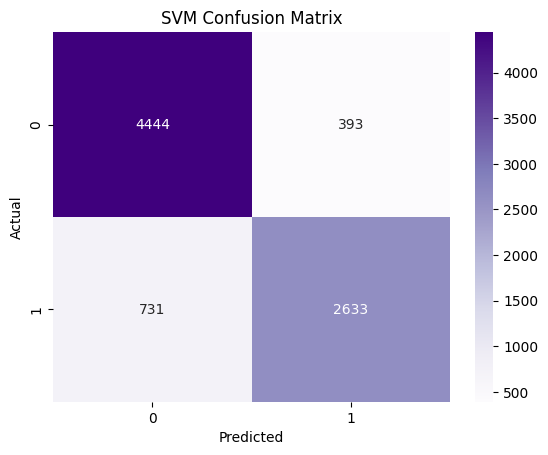

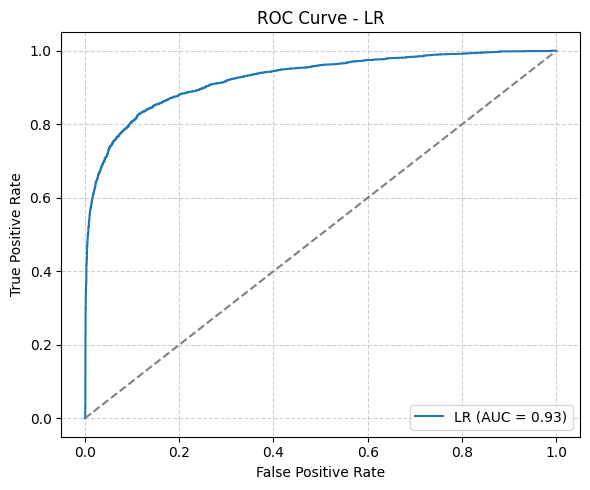

In [ ]:
# Final test evaluation
test_preds_svm = best_svm_model.predict(X_test)
test_probs_svm = best_svm_model.predict_proba(X_test)[:, 1]

print("Test (Tuned SVM):")
print(classification_report(y_test, test_preds_svm, digits = 4))
print("ROC-AUC (Test):", roc_auc_score(y_test, test_probs_svm))

# Plot
# Confusion matrix
svm_cm = confusion_matrix(y_test, test_preds_svm)
sns.heatmap(svm_cm, annot = True, fmt = 'd', cmap = 'Purples')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, test_probs_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, label = f"LR (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LR")
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()

## **2. Transformer Based Classifiers**

## **2a. BERT fine-tuning**

#### Tokenization & Tensor Conversion

The below code will take 3 mins

In [30]:
# Load BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Extract texts and labels
train_texts = train_df['essay_content'].tolist()
val_texts = val_df['essay_content'].tolist()
test_texts = test_df['essay_content'].tolist()

train_labels = train_df['label_ai_written'].tolist()
val_labels = val_df['label_ai_written'].tolist()
test_labels = test_df['label_ai_written'].tolist()

# Tokenize (returns PyTorch tensors)
train_encodings = bert_tokenizer(train_texts, padding = True, truncation = True, max_length = 256, return_tensors = 'pt')
val_encodings = bert_tokenizer(val_texts, padding = True, truncation = True, max_length = 256, return_tensors = 'pt')
test_encodings = bert_tokenizer(test_texts, padding = True, truncation = True, max_length = 256, return_tensors = 'pt')

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

# Create TensorDatasets
train_dataset_bert = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
val_dataset_bert = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_tensor)
test_dataset_bert = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_tensor)


#### DataLoaders

In [31]:
batch_size = 32

train_loader_bert = DataLoader(train_dataset_bert, batch_size = batch_size, shuffle = True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size = batch_size)
test_loader_bert = DataLoader(test_dataset_bert, batch_size = batch_size)

In [36]:
save_path = "/content/drive/MyDrive/Dessertation/bert_datasets"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save TensorDatasets
torch.save(train_dataset_bert, f"{save_path}/train_dataset.pt")
torch.save(val_dataset_bert, f"{save_path}/val_dataset.pt")
torch.save(test_dataset_bert, f"{save_path}/test_dataset.pt")

print("Datasets saved.")

Datasets saved.


#### Model Setup

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
bert_model.to(device)

optimizer = AdamW(bert_model.parameters(), lr = 2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


####  Training Loop

In [40]:
bert_save_path = "/content/drive/MyDrive/Dessertation/bert_best_model"

The below code will take 50 mins approx

In [41]:
EPOCHS = 10
best_val_loss = float('inf')
patience = 2
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
  print(f"\nEpoch {epoch+1}/{EPOCHS}")

  # Training
  bert_model.train()
  total_train_loss = 0

  for batch in tqdm(train_loader_bert):
    optimizer.zero_grad()
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    outputs = bert_model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
    loss = outputs.loss
    total_train_loss += loss.item()

    loss.backward()
    optimizer.step()

  avg_train_loss = total_train_loss / len(train_loader_bert)
  train_losses.append(avg_train_loss)
  print(f"Average Training Loss: {avg_train_loss:.4f}")

  # Validation
  bert_model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for batch in val_loader_bert:
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      labels = batch[2].to(device)

      outputs = bert_model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
      loss = outputs.loss
      val_loss += loss.item()

      preds = torch.argmax(outputs.logits, dim=1)
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

  avg_val_loss = val_loss / len(val_loader_bert)
  val_accuracy = val_correct / val_total
  val_losses.append(avg_val_loss)
  print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

  # Early Stopping
  if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
      best_epoch = epoch

      #saving the model
      bert_model.save_pretrained(bert_save_path)
      bert_tokenizer.save_pretrained(bert_save_path)
      print(f"Best model saved to: {bert_save_path}")
  else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered.")
          break



Epoch 1/10


100%|██████████| 479/479 [10:27<00:00,  1.31s/it]


Average Training Loss: 0.0593
Validation Loss: 0.0270 | Validation Accuracy: 0.9906
Best model saved to: /content/drive/MyDrive/Dessertation/bert_best_model

Epoch 2/10


100%|██████████| 479/479 [10:26<00:00,  1.31s/it]


Average Training Loss: 0.0108
Validation Loss: 0.0137 | Validation Accuracy: 0.9958
Best model saved to: /content/drive/MyDrive/Dessertation/bert_best_model

Epoch 3/10


100%|██████████| 479/479 [10:26<00:00,  1.31s/it]


Average Training Loss: 0.0079
Validation Loss: 0.0235 | Validation Accuracy: 0.9940

Epoch 4/10


100%|██████████| 479/479 [10:26<00:00,  1.31s/it]


Average Training Loss: 0.0042
Validation Loss: 0.0183 | Validation Accuracy: 0.9950
Early stopping triggered.


#### Training VS Validation Loss

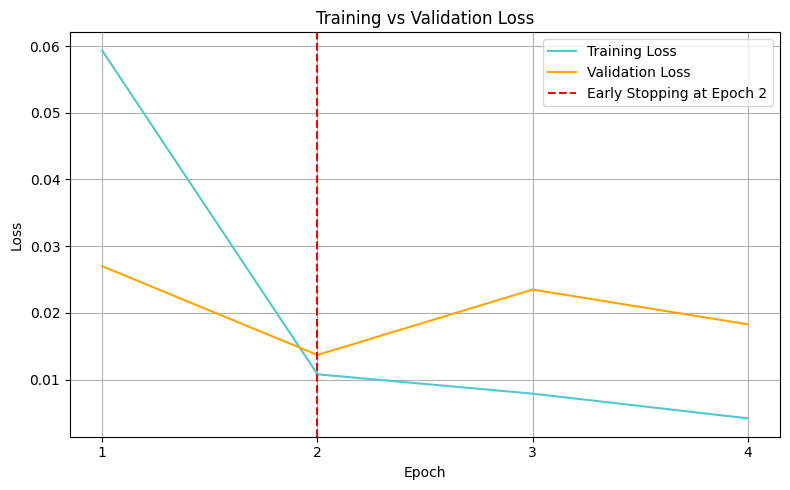

In [30]:
epochs_ran = len(val_losses)

plt.figure(figsize = (8, 5))
plt.plot(range(1, epochs_ran + 1), train_losses, label = "Training Loss", color = '#50C9CE')
plt.plot(range(1, epochs_ran + 1), val_losses, label = "Validation Loss", color = 'orange')
plt.axvline(best_epoch + 1, color = 'r', linestyle = '--', label = f"Early Stopping at Epoch {best_epoch+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.xticks(range(1, epochs_ran + 1))
plt.tight_layout()
plt.show()

#### Loading the model

In [27]:
# Load model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(bert_save_path)
bert_model = BertForSequenceClassification.from_pretrained(bert_save_path)
bert_model.to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Dessertation/bert_best_model and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.enco

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### Final Evaluation on Test Set

In [47]:
bert_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader_bert:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = bert_model(input_ids = input_ids, attention_mask = attention_mask)
        logits = outputs.logits

        probs = torch.softmax(logits, dim = 1)[:, 1]
        preds = torch.argmax(logits, dim = 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

#### Classification report, Confusion Matrix & ROC Curve

Classification Report:
              precision    recall  f1-score   support

           0     0.9985    0.9905    0.9945      4837
           1     0.9865    0.9979    0.9922      3364

    accuracy                         0.9935      8201
   macro avg     0.9925    0.9942    0.9933      8201
weighted avg     0.9936    0.9935    0.9935      8201

ROC-AUC Score: 0.9998


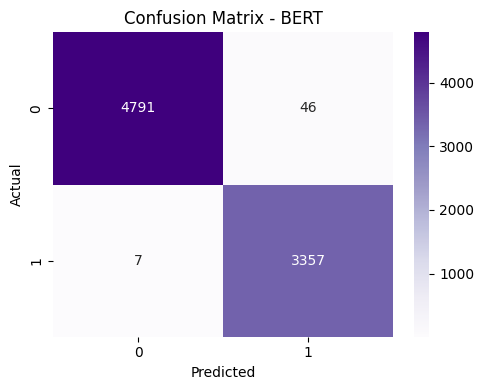

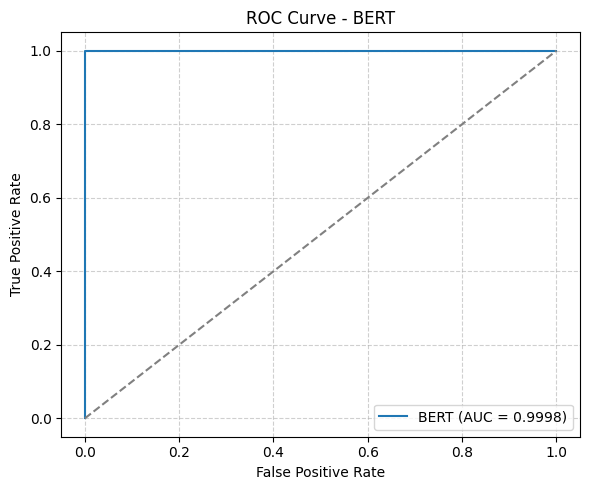

In [48]:
# Print metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits = 4))

cm = confusion_matrix(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion matrix plot
plt.figure(figsize = (5, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Purples')
plt.title("Confusion Matrix - BERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, label = f"BERT (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BERT")
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()

The model is not just memorizing training data, it’s generalizing.

task is binary and the text structure of human vs. AI essays can be quite distinguishable using BERT.

The dataset is well-labeled, fairly large, and BERT has seen similar patterns during pretraining.

## **2b. RoBERTa**

#### Tokenization & Tensor Conversion

In [49]:
# Load RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Extract texts and labels
train_texts = train_df['essay_content'].tolist()
val_texts = val_df['essay_content'].tolist()
test_texts = test_df['essay_content'].tolist()

train_labels = train_df['label_ai_written'].tolist()
val_labels = val_df['label_ai_written'].tolist()
test_labels = test_df['label_ai_written'].tolist()

# Tokenize
train_encodings = roberta_tokenizer(train_texts, padding = True, truncation = True, max_length = 256, return_tensors = 'pt')
val_encodings = roberta_tokenizer(val_texts, padding = True, truncation = True, max_length = 256, return_tensors = 'pt')
test_encodings = roberta_tokenizer(test_texts, padding = True, truncation = True, max_length = 256, return_tensors = 'pt')

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

# Create datasets
train_dataset_roberta = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
val_dataset_roberta = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_tensor)
test_dataset_roberta = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_tensor)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

#### DataLoaders

In [50]:
batch_size = 32

train_loader_roberta = DataLoader(train_dataset_roberta, batch_size = batch_size, shuffle = True)
val_loader_roberta = DataLoader(val_dataset_roberta, batch_size = batch_size)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size = batch_size)

In [51]:
save_path = "/content/drive/MyDrive/Dessertation/roberta_datasets"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save TensorDatasets
torch.save(train_dataset_roberta, f"{save_path}/train_dataset.pt")
torch.save(val_dataset_roberta, f"{save_path}/val_dataset.pt")
torch.save(test_dataset_roberta, f"{save_path}/test_dataset.pt")

print("Datasets saved.")

Datasets saved.


#### Model Setup

In [52]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
# Load RoBERTa model
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = 2)
roberta_model.to(device)

# Optimizer
roberta_optimizer = AdamW(roberta_model.parameters(), lr = 2e-5)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


####  Training Loop

In [54]:
roberta_save_path = "/content/drive/MyDrive/Dessertation/roberta_model"

The below code runs for 50 mins approx

In [59]:
EPOCHS = 10
patience = 2
patience_counter = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Train
    roberta_model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader_roberta):
        roberta_optimizer.zero_grad()
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        outputs = roberta_model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        roberta_optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader_roberta)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # Validation
    roberta_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader_roberta:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            outputs = roberta_model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim = 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader_roberta)
    val_losses.append(avg_val_loss)
    val_accuracy = val_correct / val_total
    print(f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_epoch = epoch

        #saving the model
        roberta_model.save_pretrained(roberta_save_path)
        roberta_tokenizer.save_pretrained(roberta_save_path)
        print(f"Best model saved to: {roberta_save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/10


100%|██████████| 479/479 [10:29<00:00,  1.31s/it]


Training Loss: 0.0020
Validation Loss: 0.0128 | Accuracy: 0.9971
Best model saved to: /content/drive/MyDrive/Dessertation/roberta_model

Epoch 2/10


100%|██████████| 479/479 [10:28<00:00,  1.31s/it]


Training Loss: 0.0001
Validation Loss: 0.0273 | Accuracy: 0.9956

Epoch 3/10


100%|██████████| 479/479 [10:28<00:00,  1.31s/it]


Training Loss: 0.0073
Validation Loss: 0.0145 | Accuracy: 0.9974
Early stopping triggered.


#### Train VS Validation Loss

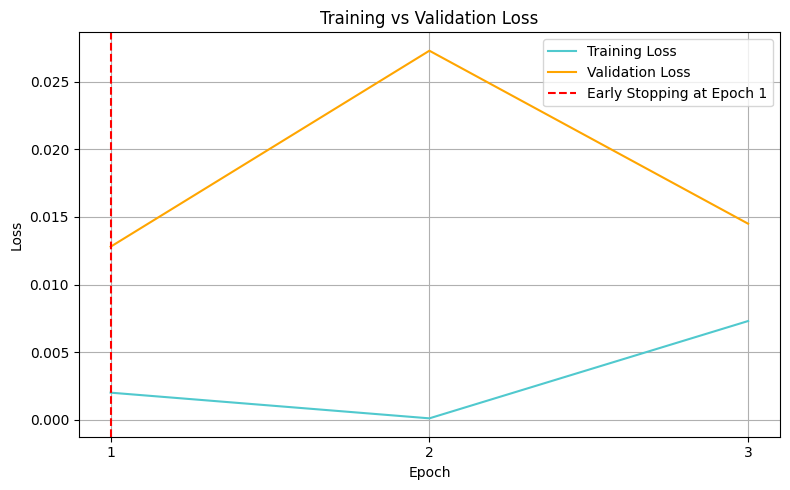

In [33]:
epochs_ran = len(val_losses)

plt.figure(figsize = (8, 5))
plt.plot(range(1, epochs_ran + 1), train_losses, label = "Training Loss", color = '#50C9CE')
plt.plot(range(1, epochs_ran + 1), val_losses, label = "Validation Loss", color = 'orange')
plt.axvline(best_epoch + 1, color = 'r', linestyle = '--', label = f"Early Stopping at Epoch {best_epoch+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.xticks(range(1, epochs_ran + 1))
plt.tight_layout()
plt.show()

#### Load the model

In [ ]:
# Load model and tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_save_path)
roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_save_path)
roberta_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

#### Final Evaluation on Test Set

In [61]:
roberta_model.eval()
all_preds_rob = []
all_labels_rob = []
all_probs_rob = []

with torch.no_grad():
    for batch in test_loader_roberta:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = roberta_model(input_ids = input_ids, attention_mask = attention_mask)
        logits = outputs.logits

        probs_rob = torch.softmax(logits, dim = 1)[:, 1]
        preds_rob = torch.argmax(logits, dim = 1)

        all_preds_rob.extend(preds_rob.cpu().numpy())
        all_labels_rob.extend(labels.cpu().numpy())
        all_probs_rob.extend(probs_rob.cpu().numpy())

#### Classification report, Confusion Matrix & ROC Curve

Classification Report — RoBERTa
              precision    recall  f1-score   support

           0     0.9986    0.9981    0.9983      4837
           1     0.9973    0.9979    0.9976      3364

    accuracy                         0.9980      8201
   macro avg     0.9979    0.9980    0.9980      8201
weighted avg     0.9980    0.9980    0.9980      8201

ROC-AUC Score: 0.9998


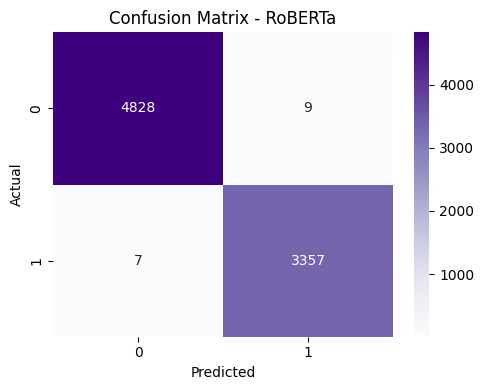

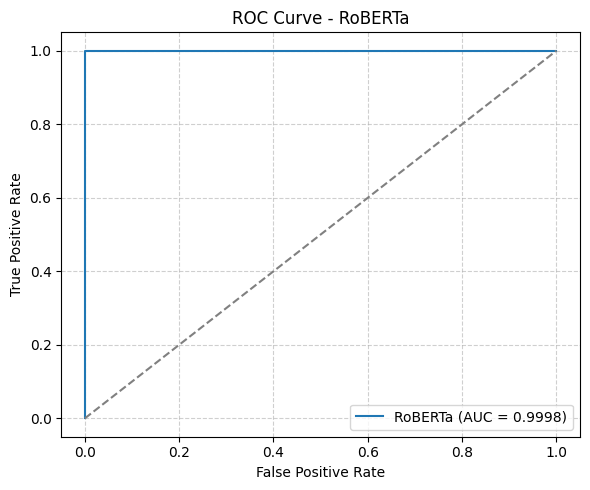

In [49]:
# Metrics
print("Classification Report:")
print(classification_report(all_labels_rob, all_preds_rob, digits = 4))

cm = confusion_matrix(all_labels_rob, all_preds_rob)
roc_auc = roc_auc_score(all_labels_rob, all_probs_rob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix Plot
plt.figure(figsize = (5, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Purples')
plt.title("Confusion Matrix - RoBERTa")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels_rob, all_probs_rob)
plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, label = f"RoBERTa (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RoBERTa")
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()

Excellent ROC-AUC score (0.9998) indicates the model discriminates well between classes.

Only 1 AI-generated text misclassified as human, showing very high sensitivity to AI text.


RoBERTa achieves higher overall accuracy and macro F1-score, which shows more balanced performance across both classes.


# **Perplexity**

Now that I’ve trained and tested my classifiers, I’m using GPT-2 perplexity to understand how natural or fluent the texts appear to a pre-trained language model. This helps explain why some essays are harder to classify and whether fluency correlates with being AI-written.

1. This lets to diagnose:

Why some human texts may be misclassified as AI

Whether AI-generated texts are systematically “simpler” or more “model-like”

2. Helps Explain Model Behavior
If the classifier mislabels a human essay as AI, and that essay also has very low perplexity, it shows the model was fooled by language that looked machine-like.

Conversely, high-perplexity AI texts may explain false negatives.

#### Load GPT-2 Model and Tokenizer

In [ ]:
# Use GPT-2 (small version for speed)
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# Move to GPU if available
gpt2_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2_model.to(gpt2_device)
gpt2_model.eval()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

#### Perplexity Calculation Function

In [ ]:
def calculate_perplexity(text, model, tokenizer, device):
  encodings = tokenizer(text, return_tensors = 'pt', truncation = True, max_length = 512)
  input_ids = encodings.input_ids.to(device)

  with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    perplexity = torch.exp(loss).item()

  return perplexity

#### Sample and Compute Perplexities

In [ ]:
# Sample 300 human and 300 AI essays
human_samples = test_df[test_df['label_ai_written'] == 0].sample(300, random_state = 42)['essay_content'].tolist()
ai_samples = test_df[test_df['label_ai_written'] == 1].sample(300, random_state = 42)['essay_content'].tolist()

# Compute perplexity for each
human_perplexities = [calculate_perplexity(text, gpt2_model, gpt2_tokenizer, gpt2_device) for text in tqdm(human_samples, desc = "Human")]
ai_perplexities = [calculate_perplexity(text, gpt2_model, gpt2_tokenizer, gpt2_device) for text in tqdm(ai_samples, desc = "AI")]


AI: 100%|██████████| 300/300 [00:10<00:00, 27.94it/s]


#### Visualize Perplexity Distributions

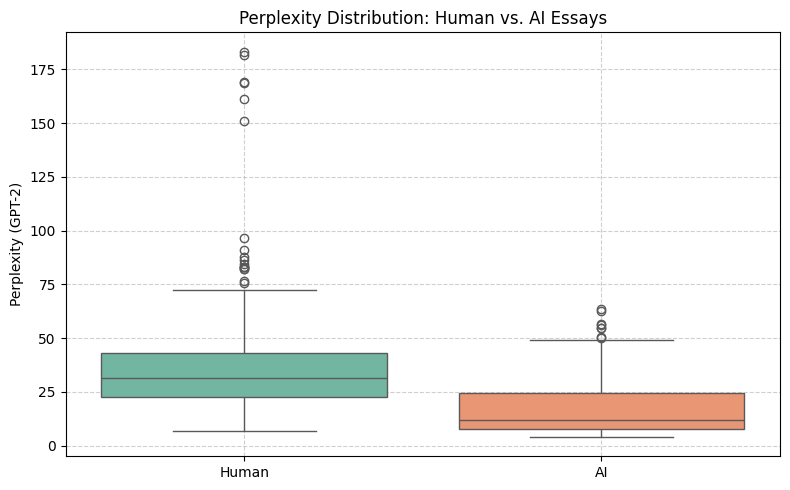

Average Perplexity (Human): 37.206687434514365
Average Perplexity (AI): 17.181030842463176


In [ ]:
perplexity_df = pd.DataFrame({'perplexity': human_perplexities + ai_perplexities,
                              'label': ['Human'] * len(human_perplexities) + ['AI'] * len(ai_perplexities)})

# Boxplot
plt.figure(figsize = (8, 5))
sns.boxplot(x = 'label', y = 'perplexity', data = perplexity_df, palette = 'Set2')
plt.title("Perplexity Distribution: Human vs. AI Essays")
plt.ylabel("Perplexity (GPT-2)")
plt.xlabel("")
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()

print("Average Perplexity (Human):", np.mean(human_perplexities))
print("Average Perplexity (AI):", np.mean(ai_perplexities))

1. Human-written essays have significantly higher perplexity
Mean perplexity (Human): ~37.2

Distribution is broader and includes more outliers

This suggests that human writing is more linguistically diverse and less predictable for GPT-2

2. AI-generated essays have lower perplexity
Mean perplexity (AI): ~17.2

AI text tends to be more predictable and fluent in ways GPT-2 can easily model, possibly due to being generated by similar systems (e.g., GPT-3)

3. Separation supports detectability
The gap between distributions shows that GPT-2 perplexity can be a useful indicator of machine-generated content

While not perfect for classification, it provides valuable diagnostic insight and interpretability



# **Cross Domain Testing**

#### Load Dataset

In [50]:
webtext_path = "/content/drive/MyDrive/Dessertation/webtext.test.jsonl"
gpt2_path = "/content/drive/MyDrive/Dessertation/small-117M.test.jsonl"

# Function to load texts from a JSONL file
def load_jsonl_texts(path):
  texts = []
  with open(path, 'r', encoding = 'utf-8') as f:
    for line in f:
      item = json.loads(line)
      text = item.get("text", "").strip()
      if text:  # Skip empty entries
        texts.append(text)
  return texts

# Load texts
webtext_texts = load_jsonl_texts(webtext_path)
gpt2_texts = load_jsonl_texts(gpt2_path)

# Balance sample sizes
min_len = min(len(webtext_texts), len(gpt2_texts))
webtext_texts = webtext_texts[:min_len]
gpt2_texts = gpt2_texts[:min_len]

# Create combined dataframe
cross_domain_df = pd.DataFrame({'text': webtext_texts + gpt2_texts, 'label': [0] * min_len + [1] * min_len})

print("Cross-domain dataset shape:", cross_domain_df.shape)
display(cross_domain_df.head())

Cross-domain dataset shape: (9978, 2)


,text,label
0,Is this restaurant family-friendly ? Yes No Un...,0
1,Clinton talks about her time of 'reflection' d...,0
2,House Majority Whip Steve Scalise has been dis...,0
3,Insight Course: Lesson 14\n\nControl of the Mi...,0
4,BY JENNIE MCNULTY\n\nLesbian.com\n\nYou know W...,0


In [51]:
cross_domain_df['label'].value_counts()

,count
label,
0,4989
1,4989


#### Tokenize and Prepare DataLoader

In [52]:
# Load the same tokenizer used during training

# Tokenize the cross-domain texts
encodings = roberta_tokenizer(cross_domain_df['text'].tolist(),
                              padding = True,
                              truncation = True,
                              max_length = 256,
                              return_tensors = 'pt')

# Labels to tensor
labels_tensor = torch.tensor(cross_domain_df['label'].tolist())

# Create dataset and loader
cross_dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels_tensor)
cross_loader = DataLoader(cross_dataset, batch_size = 32)

#### Evaluate BERT on Cross-Domain Dataset

In [66]:
# Ensure model is in eval mode
roberta_model.eval()

all_preds_cross = []
all_labels_cross = []
all_probs_cross = []

with torch.no_grad():
  for batch in cross_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    outputs = roberta_model(input_ids = input_ids, attention_mask = attention_mask)
    logits = outputs.logits

    probs = torch.softmax(logits, dim = 1)[:, 1]
    preds = torch.argmax(logits, dim = 1)

    all_preds_cross.extend(preds.cpu().numpy())
    all_labels_cross.extend(labels.cpu().numpy())
    all_probs_cross.extend(probs.cpu().numpy())

#### Visualization

Classification Report — Cross-Domain RoBERTa
              precision    recall  f1-score   support

           0     0.3803    0.5282    0.4422      4989
           1     0.2279    0.1393    0.1729      4989

    accuracy                         0.3337      9978
   macro avg     0.3041    0.3337    0.3076      9978
weighted avg     0.3041    0.3337    0.3076      9978

ROC-AUC Score: 0.2418


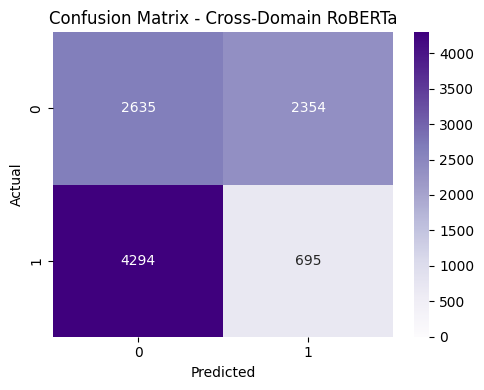

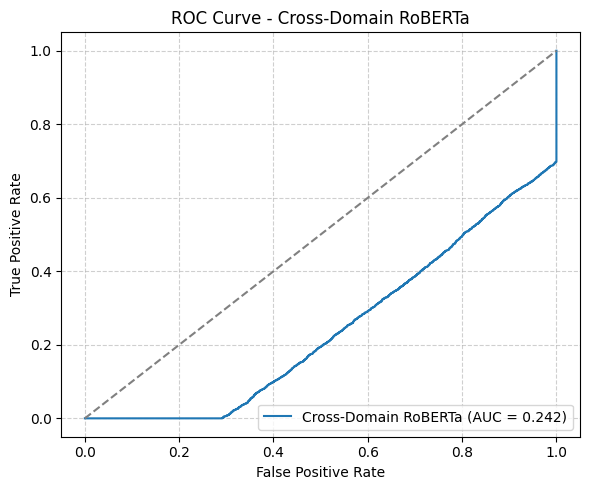

In [57]:
# Print metrics
print("Classification Report (Cross-Domain):")
print(classification_report(all_labels_cross, all_preds_cross, digits = 4))

# Confusion matrix
cm = confusion_matrix(all_labels_cross, all_preds_cross)
roc_auc = roc_auc_score(all_labels_cross, all_probs_cross)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot confusion matrix
plt.figure(figsize = (5, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Purples')
plt.title("Confusion Matrix - Cross-Domain (RoBERTa)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels_cross, all_probs_cross)
plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, label = f"Cross-Domain BERT (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Cross-Domain")
plt.legend(loc = "lower right")
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()
